## <center> Road Traffic Prediction : EDA, Prophet, SARIMA and SARIMAX </center>

#### Context
Traffic congestion is increasing in cities worldwide, driven by growing urban populations, outdated infrastructure, poorly coordinated traffic signals, and a lack of real-time data. The consequences are substantial. According to traffic data and analytics firm INRIX, U.S. commuters lost $305 billion in 2017 due to wasted fuel, lost time, and higher costs of transporting goods through congested areas. With limited physical space and financial resources to build more roads, cities need to adopt new strategies and technologies to enhance traffic management.
#### Content
This dataset contains 48.1k (48120) observations of the number of vehicles each hour in four different junctions. In this project, we'll focus solely on data from Junction 1.

In [1]:
# !pip install prophet
# !pip install holidays

In [2]:
# pip install pmdarima

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
import holidays
from sklearn.linear_model import LinearRegression
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

## Import time series data

In [5]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1GO0WgbDW6UmYqxj5154QF6FvDDhLeWJ7_EgyMcDK2YM/export?format=csv',index_col=[0],parse_dates=[0])
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [6]:
df = df.reset_index()
df['DateTime'] = pd.to_datetime(df['DateTime'])  # Ensure it's in datetime format
df.set_index('DateTime', inplace=True)  # Set it back as the index


In [7]:
df

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041
...,...,...,...
2017-06-30 19:00:00,4,11,20170630194
2017-06-30 20:00:00,4,30,20170630204
2017-06-30 21:00:00,4,16,20170630214


## Pre-processing

In [8]:
df = df[df['Junction'] == 1]             # Filter for Junction 1
df = df.drop(columns=['ID', 'Junction']) # Drop the 'ID' and 'Junction' columns
df.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


In [9]:
df.shape

(14592, 1)

In [10]:
# check for missing values and fill them if there
if(df.isnull().sum().sum()==0):
    print('No missing values.')
else:
    df.fillna(method='ffill',inplace=True)

No missing values.


## Feature engineering

In [11]:
cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday',
                                        'Thursday','Friday','Saturday','Sunday'],
                            ordered=True)
us_holidays = holidays.US(years=[2015, 2016, 2017])

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['isholiday'] = df['date'].dt.normalize().isin(us_holidays)
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','isholiday','weekday','month','year','season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Vehicles')
features_and_target = pd.concat([X, y], axis=1)

# Display the first few rows to verify
print(features_and_target[features_and_target['isholiday'] == True])

                     hour  isholiday    weekday  month  year  season  Vehicles
DateTime                                                                      
2015-11-11 00:00:00     0       True  Wednesday     11  2015    Fall        28
2015-11-11 01:00:00     1       True  Wednesday     11  2015    Fall        25
2015-11-11 02:00:00     2       True  Wednesday     11  2015    Fall        19
2015-11-11 03:00:00     3       True  Wednesday     11  2015    Fall        21
2015-11-11 04:00:00     4       True  Wednesday     11  2015    Fall        20
...                   ...        ...        ...    ...   ...     ...       ...
2017-05-29 19:00:00    19       True     Monday      5  2017  Spring       104
2017-05-29 20:00:00    20       True     Monday      5  2017  Spring        93
2017-05-29 21:00:00    21       True     Monday      5  2017  Spring        84
2017-05-29 22:00:00    22       True     Monday      5  2017  Spring        89
2017-05-29 23:00:00    23       True     Monday     

## Data Visualization

#why hourly to monthly ->original data (df) has hourly observations, it can be noisy and difficult to interpret overall patterns

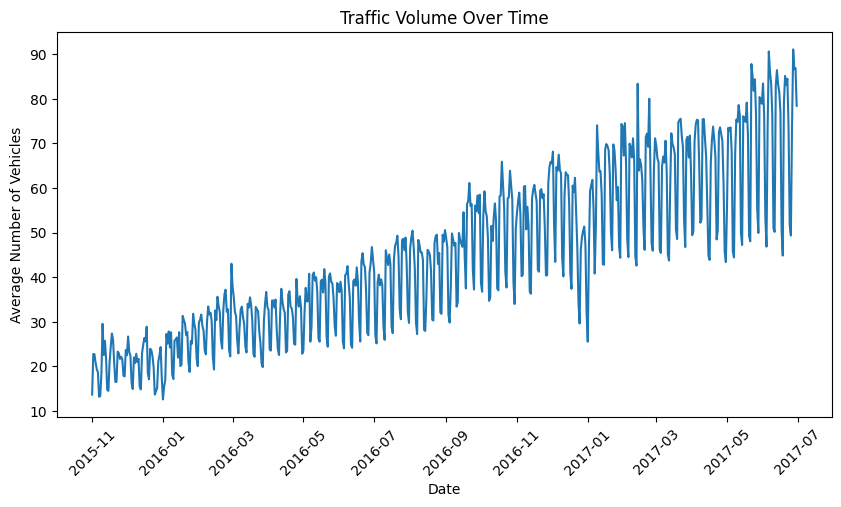

In [12]:
# For better readability, resample the data by day and take the mean
plt.figure(figsize=(10, 5))
df_daily = df.resample('D').mean()
plt.plot(df_daily.index, df_daily['Vehicles'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Number of Vehicles')
plt.show()

In [13]:
# df_daily['Vehicles'] = df_daily['Vehicles'].replace(0, np.nan).interpolate(method='linear')

In [14]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []

    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))

    return mean_func

def var_over_time(process: np.array) -> np.array:
    var_func = []

    for i in range(len(process)):
        var_func.append(np.var(process[:i]))

    return var_func

In [15]:
# Install required libraries if needed (uncomment if necessary)
# !pip install pandas numpy matplotlib statsmodels sklearn seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA  # For a pure MA model, p=0, q>0

from sklearn.metrics import mean_squared_error, r2_score
import math

# Optional: nicer plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [16]:
def adf_test(series, title=''):
    """
    Perform ADF test and print the results.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    out = dict(zip(labels, result[0:4]))
    for key, val in out.items():
        print(f"   {key} : {val}")
    for key,val in result[4].items():
        print(f"   Critical Value {key} : {val}")
    print("")

# Perform ADF test on the 'Close' prices
adf_test(df_daily['Vehicles'], 'Google Stock Close Price')


Augmented Dickey-Fuller Test: Google Stock Close Price
   ADF Test Statistic : -0.34138151020458557
   p-value : 0.9194355530673921
   # Lags Used : 18
   Number of Observations Used : 589
   Critical Value 1% : -3.4415011513018263
   Critical Value 5% : -2.8664595311890215
   Critical Value 10% : -2.569389981494346



In [17]:
# prompt: take first diff of my Vehicles

# Calculate the first difference of the 'Vehicles' column
df_daily['Vehicles_diff'] = df_daily['Vehicles'].diff()

# Print the first few rows to verify
# print(df_daily.head())
# prompt: i got difference so first value of vehicales_scaled_diff gets NaN, handle that value

# Fill the first NaN value in 'Vehicles_diff' with 0
df_daily['Vehicles_diff'].fillna(0, inplace=True)

# Print the first few rows to verify
print(df_daily.head())


             Vehicles  Vehicles_diff
DateTime                            
2015-11-01  13.625000       0.000000
2015-11-02  22.750000       9.125000
2015-11-03  22.666667      -0.083333
2015-11-04  20.750000      -1.916667
2015-11-05  19.333333      -1.416667


In [18]:
adf_test(df_daily['Vehicles_diff'], 'Google Stock Close Price')

Augmented Dickey-Fuller Test: Google Stock Close Price
   ADF Test Statistic : -8.92982556240143
   p-value : 9.884150674419338e-15
   # Lags Used : 19
   Number of Observations Used : 588
   Critical Value 1% : -3.44152019959894
   Critical Value 5% : -2.8664679191981297
   Critical Value 10% : -2.569394451038919



In [19]:
non_stationary_var = var_over_time(df_daily['Vehicles'])
non_stationary_mean = mean_over_time(df_daily['Vehicles'])
stationary_var = var_over_time(df_daily['Vehicles_diff'])
stationary_mean = mean_over_time(df_daily['Vehicles_diff'])

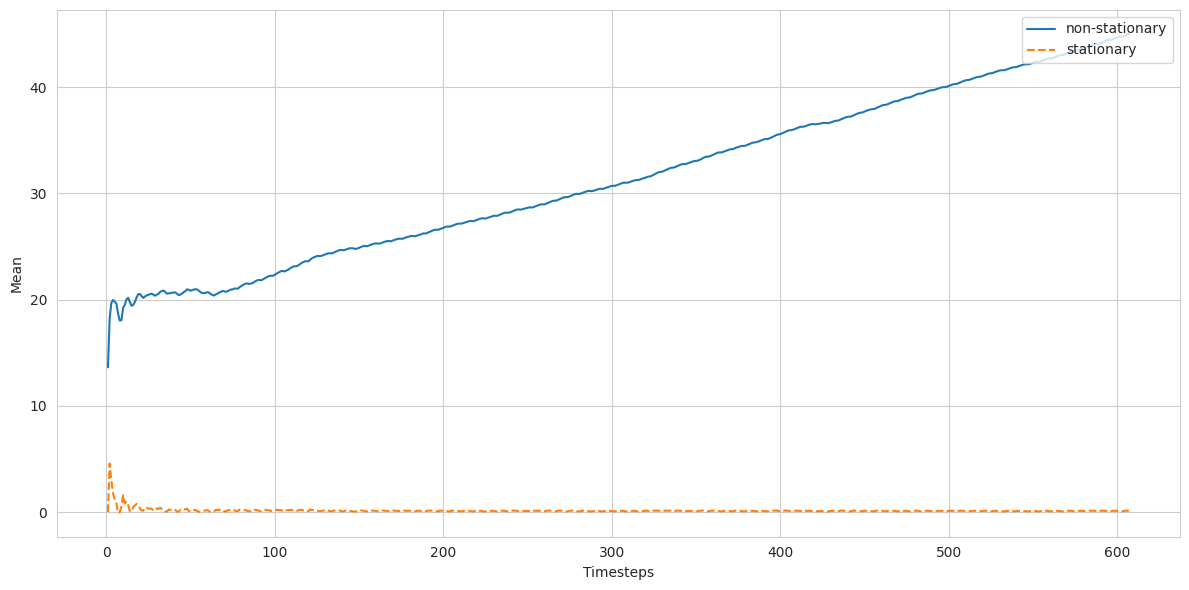

In [20]:
fig, ax = plt.subplots()

ax.plot(non_stationary_mean, linestyle='-', label='non-stationary')
ax.plot(stationary_mean, linestyle='--', label='stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()

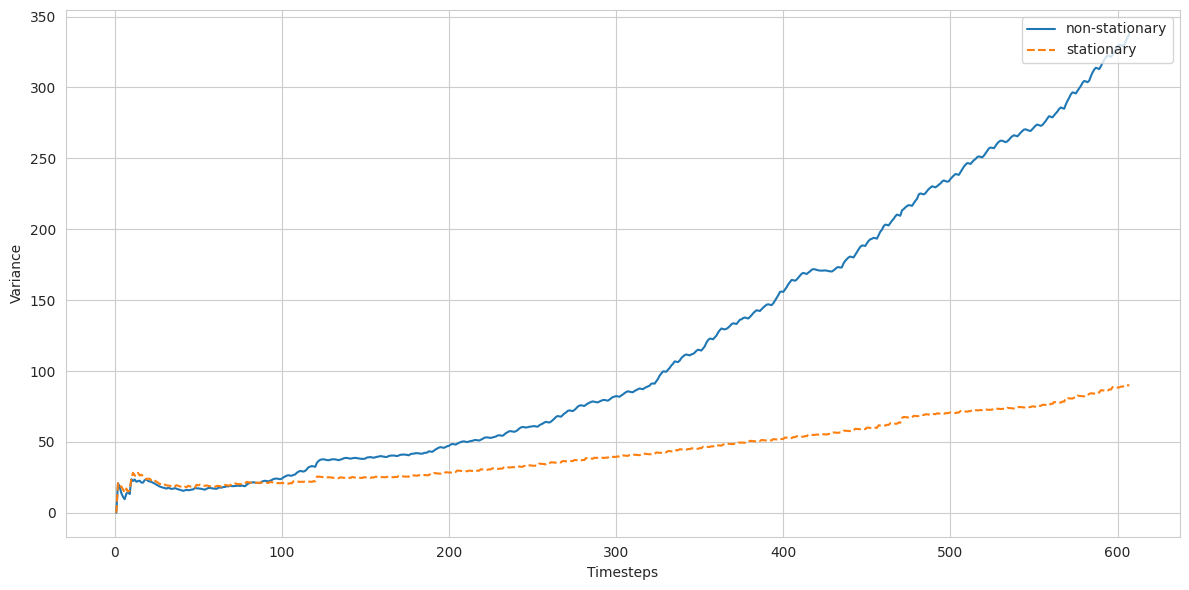

In [21]:
fig, ax = plt.subplots()

ax.plot(non_stationary_var, linestyle='-', label='non-stationary')
ax.plot(stationary_var, linestyle='--', label='stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=1)

plt.tight_layout()

#If your stationary time series still has fluctuating variance, you might need to stabilize the variance further

Check for Conditional Heteroskedasticity (ARCH Effects) Even if your data is stationary in mean, the variance might still be fluctuating due to conditional heteroskedasticity (ARCH/GARCH effects). You can check this using the ARCH test:

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch


# Example: Checking for ARCH effects (heteroskedasticity)
arch_test_p_value = het_arch(df_daily['Vehicles_diff'])[1]
print(f"ARCH Test p-value: {arch_test_p_value}")  # < 0.05 suggests volatility clustering
#If the ARCH test p-value is low (< 0.05), you have time-dependent variance (volatility clustering).


ARCH Test p-value: 2.1149139090414235e-79


Since our p value of ARCH test is less than 0.05 --> we have time-dependent varience

#2. Apply a Variance-Stabilizing Transformation
If variance is fluctuating, try:

a) Log Transformation (For High Variance Differences)
Use when variance increases with larger values.

python
Copy
Edit
df["new_series"] = df["original_series"].apply(lambda x: np.log(x) if x > 0 else np.nan)


b) Square Root Transformation (For Smaller Variance Differences)
Works for moderate variance fluctuations.

python
Copy
Edit
df["new_series"] = df["original_series"]**0.5


c) Box-Cox Transformation (Best for Strong Variance Fluctuations)
More flexible than log or square root. Requires positive values.

python
Copy
Edit
from scipy.stats import boxcox

df["new_series"], lambda_value = boxcox(df["original_series"])

In [23]:
# df_daily["Vehicles_diff_log"] = df_daily["Vehicles_diff"].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_daily["Vehicles_log"] = np.log(df_daily["Vehicles"])
df_daily["Vehicles_sqrt"] = np.sqrt(df_daily["Vehicles"])


Box-Cox lambda value: 0.37477611460652605


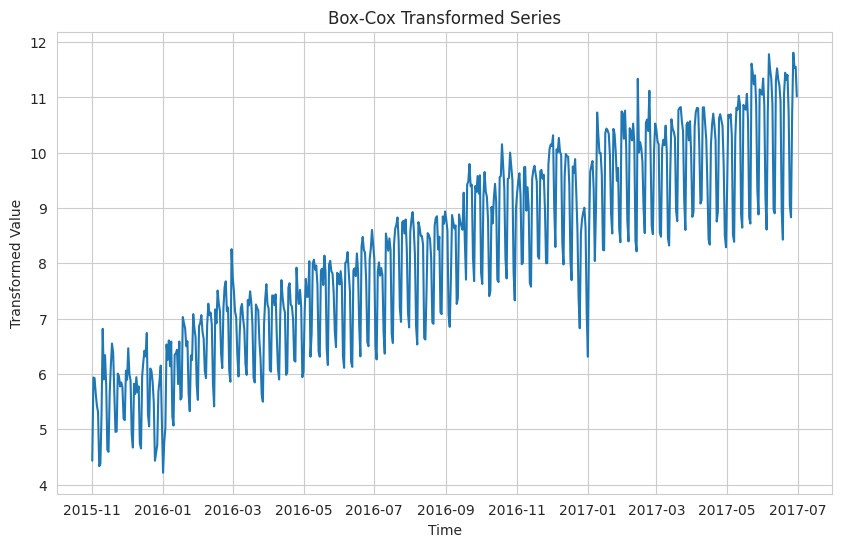

In [24]:
# prompt: apply box-cox transformation

from scipy.stats import boxcox

# Assuming df_daily and the necessary columns exist as in your provided code

# Apply Box-Cox transformation to 'Vehicles_diff'
df_daily["Vehicles_boxcox"], lambda_value = boxcox(df_daily["Vehicles"])
df_daily["Vehicles_boxcox_diff"] = pd.Series(df_daily["Vehicles_boxcox"]).diff().dropna()

print(f"Box-Cox lambda value: {lambda_value}")

# Now you can analyze or use the 'Vehicles_diff_boxcox' column
# for further time series analysis, as it has a more stable variance.

# Example: Plot the transformed series
plt.figure(figsize=(10, 6))
plt.plot(df_daily["Vehicles_boxcox"])
plt.title('Box-Cox Transformed Series')
plt.xlabel('Time')
plt.ylabel('Transformed Value')
plt.show()


#Why do we difference after Box-Cox?
Short answer:
✅ Yes, it's usually necessary to difference after Box-Cox if your data still has a trend or is not stationary in mean — because:

Box-Cox transformation helps to stabilize variance (i.e., handles heteroscedasticity).

But it does not remove trends or seasonality, so your mean may still not be stationary

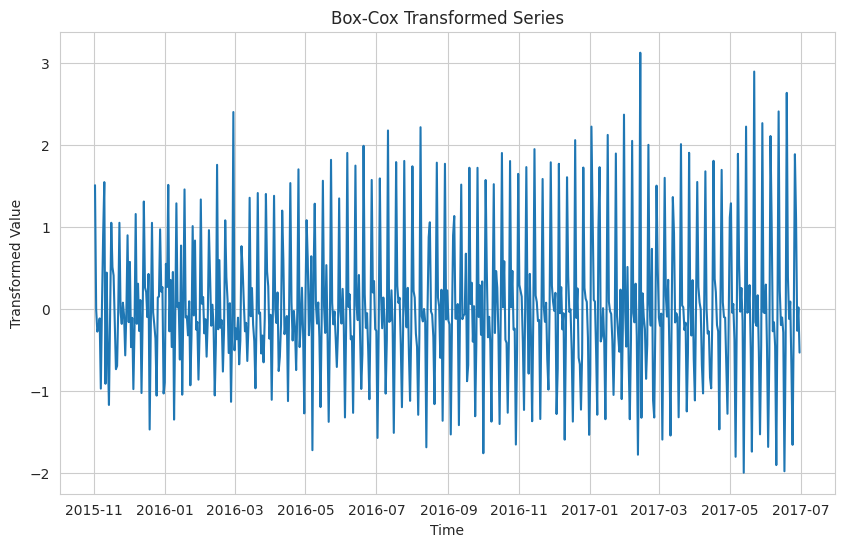

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df_daily["Vehicles_boxcox_diff"])
plt.title('Box-Cox Transformed Series')
plt.xlabel('Time')
plt.ylabel('Transformed Value')
plt.show()


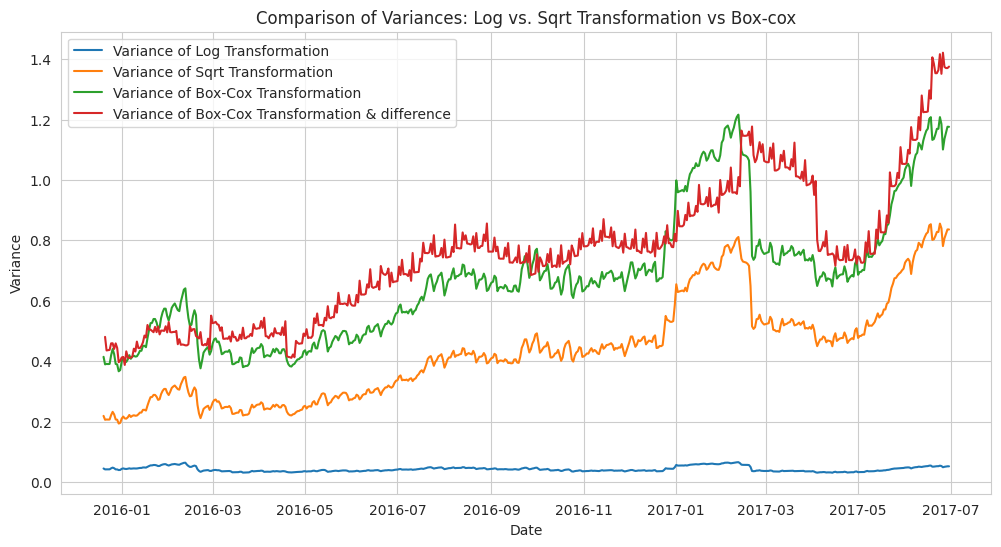

In [26]:
# prompt: for df_daily plot it's varience of _log and _sqrt and compare it with each other

# Assuming df_daily is already defined and populated as in the provided code.

# Calculate variances of log and sqrt transformations
df_daily['Vehicles_log_var'] = df_daily['Vehicles_log'].rolling(window=50).var()
df_daily['Vehicles_sqrt_var'] = df_daily['Vehicles_sqrt'].rolling(window=50).var()
df_daily['Vehicles_boxcox_var'] = df_daily['Vehicles_boxcox'].rolling(window=50).var()
df_daily['Vehicles_boxcox_diff_var'] = df_daily['Vehicles_boxcox_diff'].rolling(window=50).var()


# Plotting the variances
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['Vehicles_log_var'], label='Variance of Log Transformation')
plt.plot(df_daily.index, df_daily['Vehicles_sqrt_var'], label='Variance of Sqrt Transformation')
plt.plot(df_daily.index, df_daily['Vehicles_boxcox_var'], label='Variance of Box-Cox Transformation')
plt.plot(df_daily.index, df_daily['Vehicles_boxcox_diff_var'], label='Variance of Box-Cox Transformation & difference')

plt.xlabel('Date')
plt.ylabel('Variance')
plt.title('Comparison of Variances: Log vs. Sqrt Transformation vs Box-cox')
plt.legend()
plt.grid(True)
plt.show()


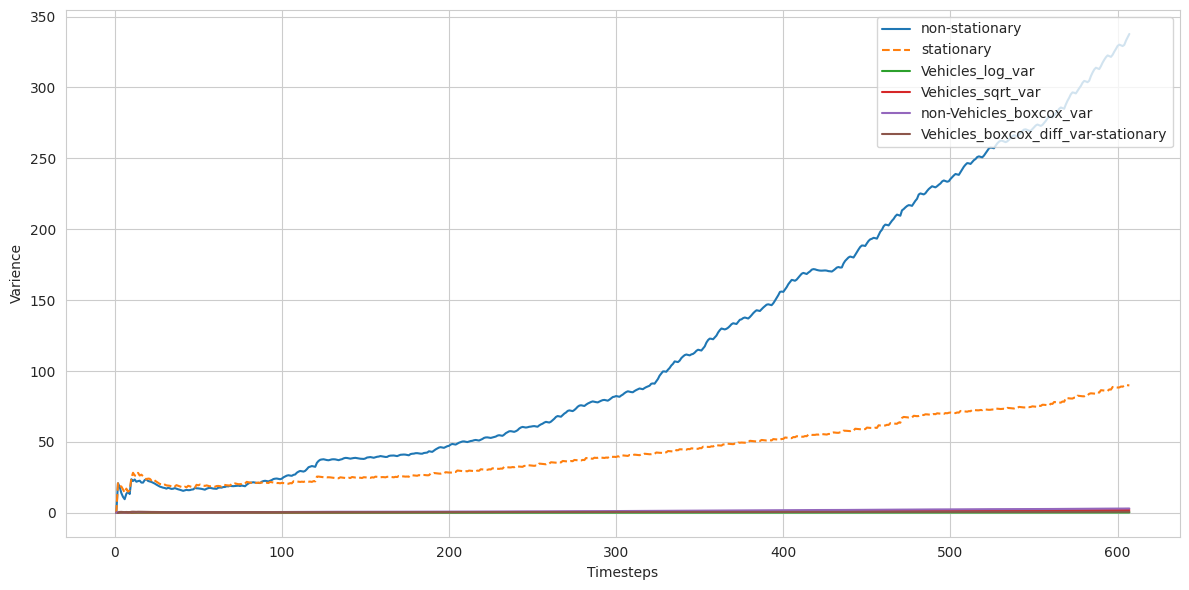

In [27]:
non_stationary_var = var_over_time(df_daily['Vehicles'])
stationary_var = var_over_time(df_daily['Vehicles_diff'])
Vehicles_log_var = var_over_time(df_daily['Vehicles_log'])
Vehicles_sqrt_var = var_over_time(df_daily['Vehicles_sqrt'])
Vehicles_boxcox_var = var_over_time(df_daily['Vehicles_boxcox'])
Vehicles_boxcox_diff_var = var_over_time(df_daily['Vehicles_boxcox_diff'])
# non_stationary_mean = mean_over_time(df_daily['Vehicles'])
# stationary_mean = mean_over_time(df_daily['Vehicles_diff'])

fig, ax = plt.subplots()

ax.plot(non_stationary_var, linestyle='-', label='non-stationary')
ax.plot(stationary_var, linestyle='--', label='stationary')
ax.plot(Vehicles_log_var, linestyle='-', label='Vehicles_log_var')
ax.plot(Vehicles_sqrt_var, linestyle='-', label='Vehicles_sqrt_var')
ax.plot(Vehicles_boxcox_var, linestyle='-', label='non-Vehicles_boxcox_var')
ax.plot(Vehicles_boxcox_diff_var, linestyle='-', label='Vehicles_boxcox_diff_var-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Varience')
ax.legend(loc=1)

plt.tight_layout()

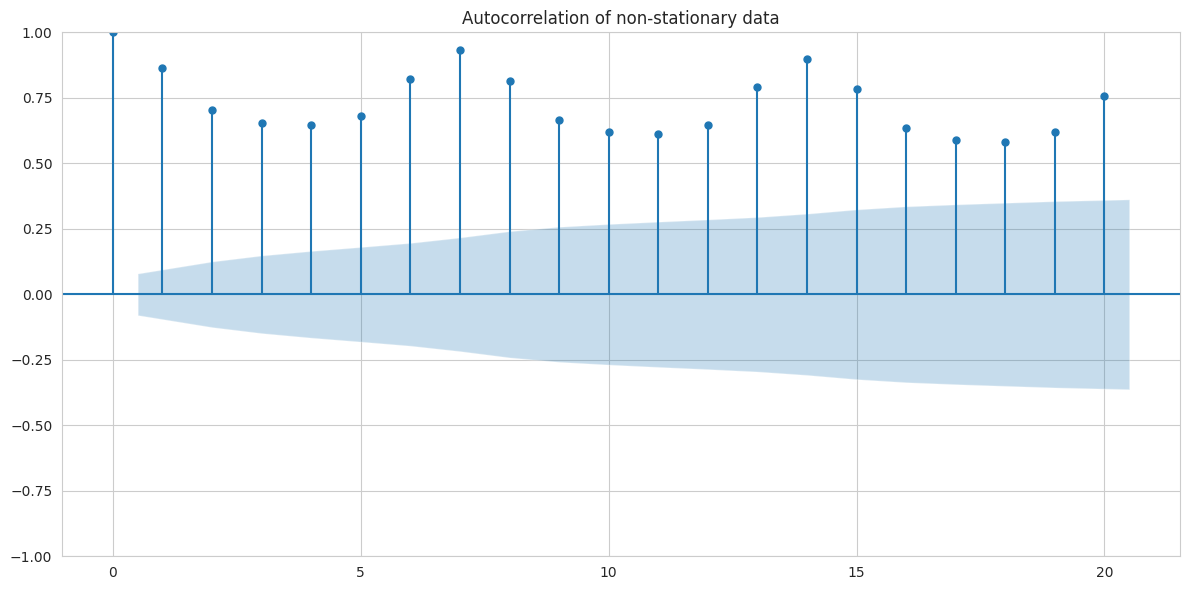

In [28]:
plot_acf(df_daily['Vehicles'], lags=20)
plt.title("Autocorrelation of non-stationary data")
plt.tight_layout()
plt.show()

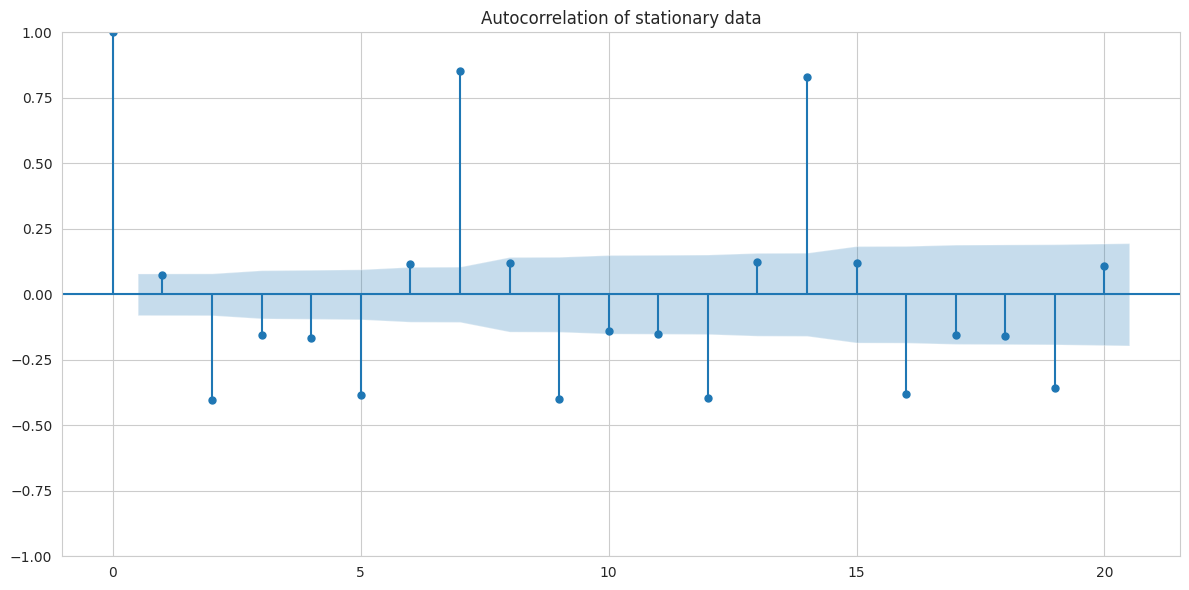

In [29]:
plot_acf(df_daily['Vehicles_diff'], lags=20);
plt.title("Autocorrelation of stationary data")
plt.tight_layout()
plt.show()

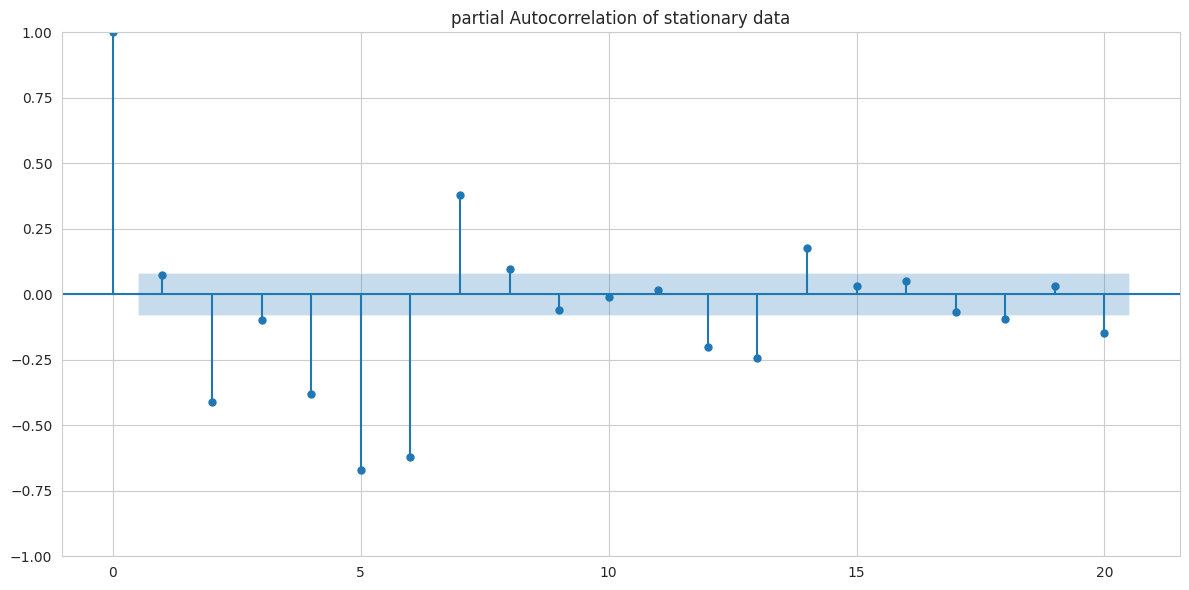

In [30]:
plot_pacf(df_daily['Vehicles_diff'], lags=20);
plt.title("partial Autocorrelation of stationary data")
plt.tight_layout()
plt.show()

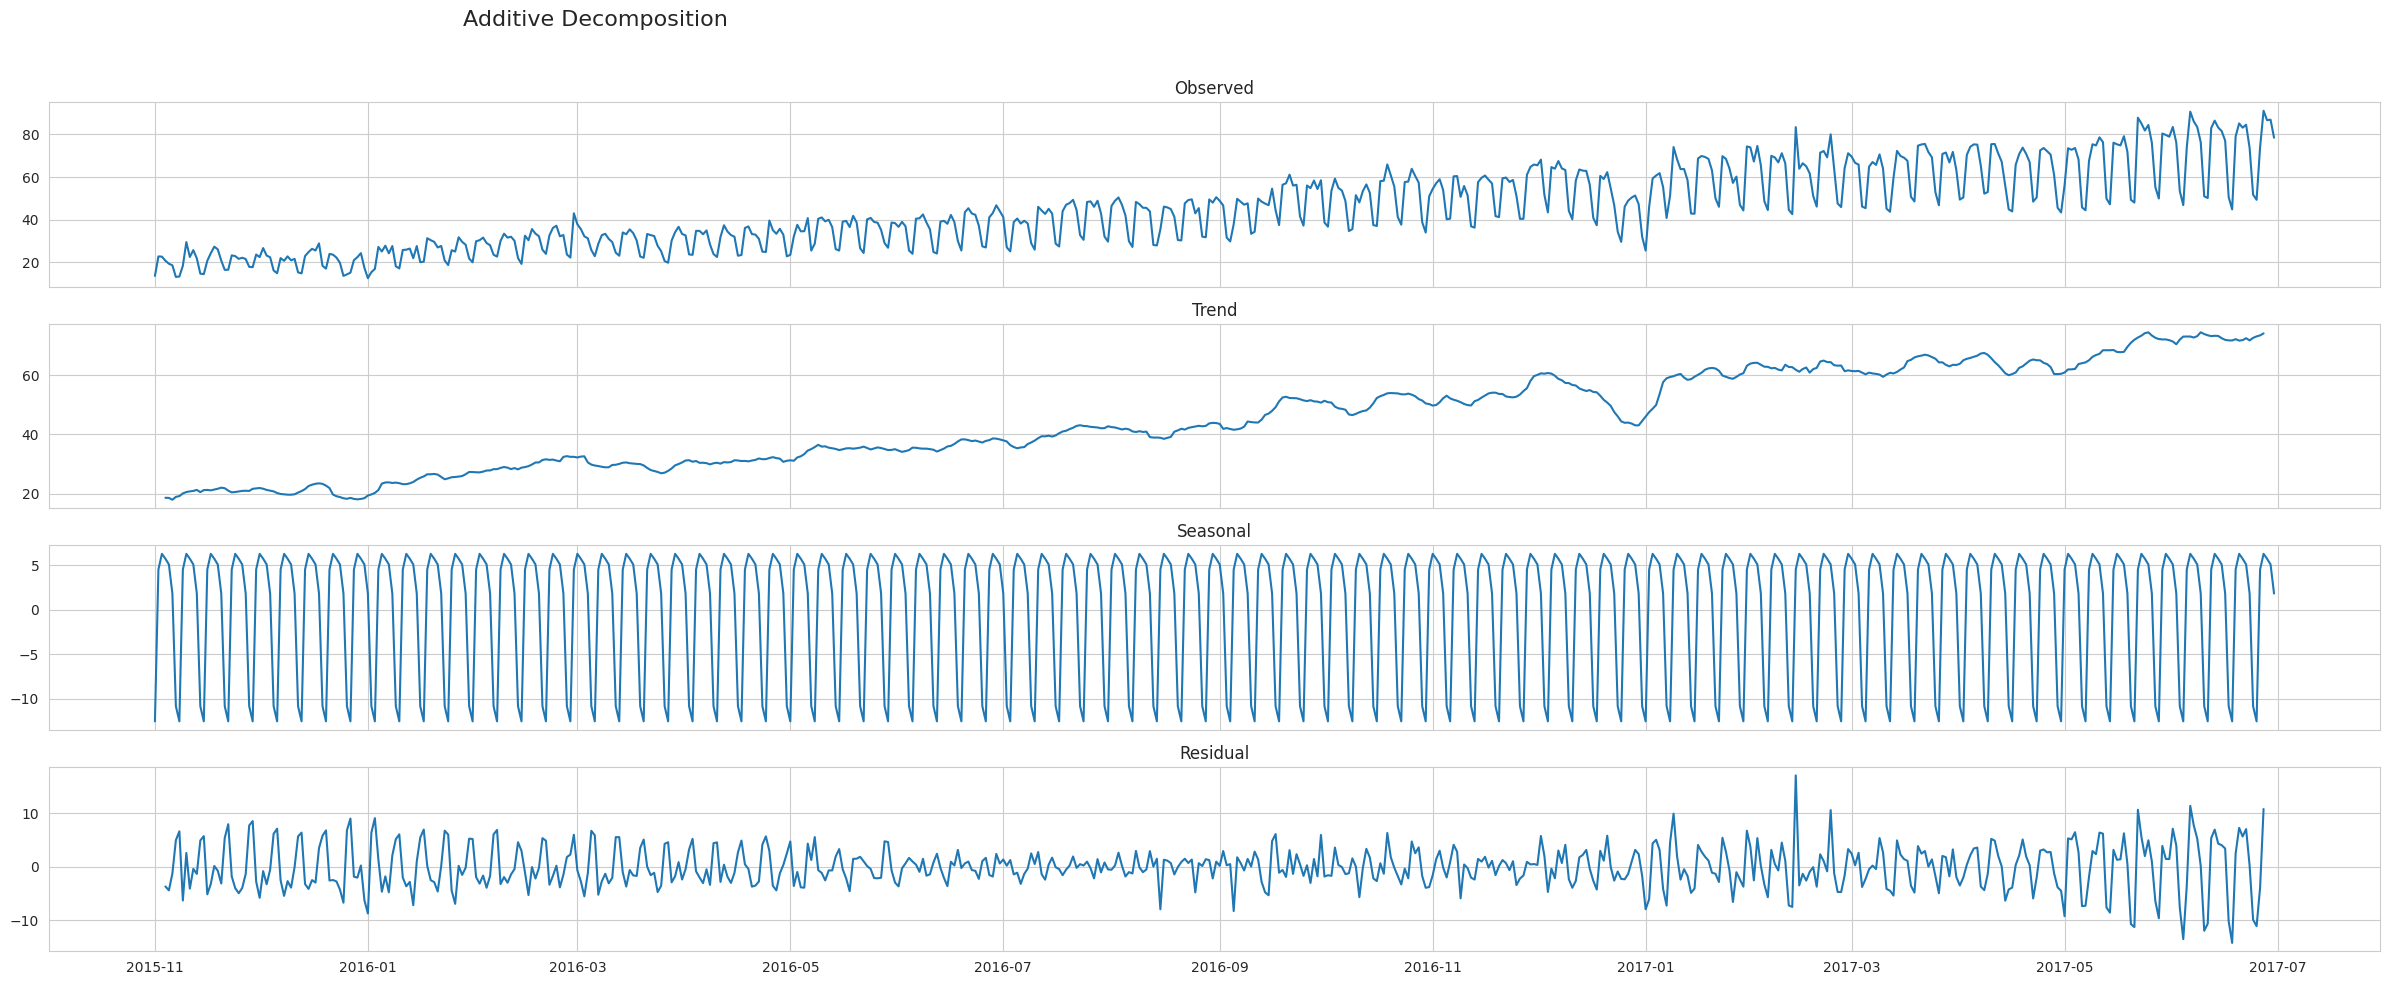

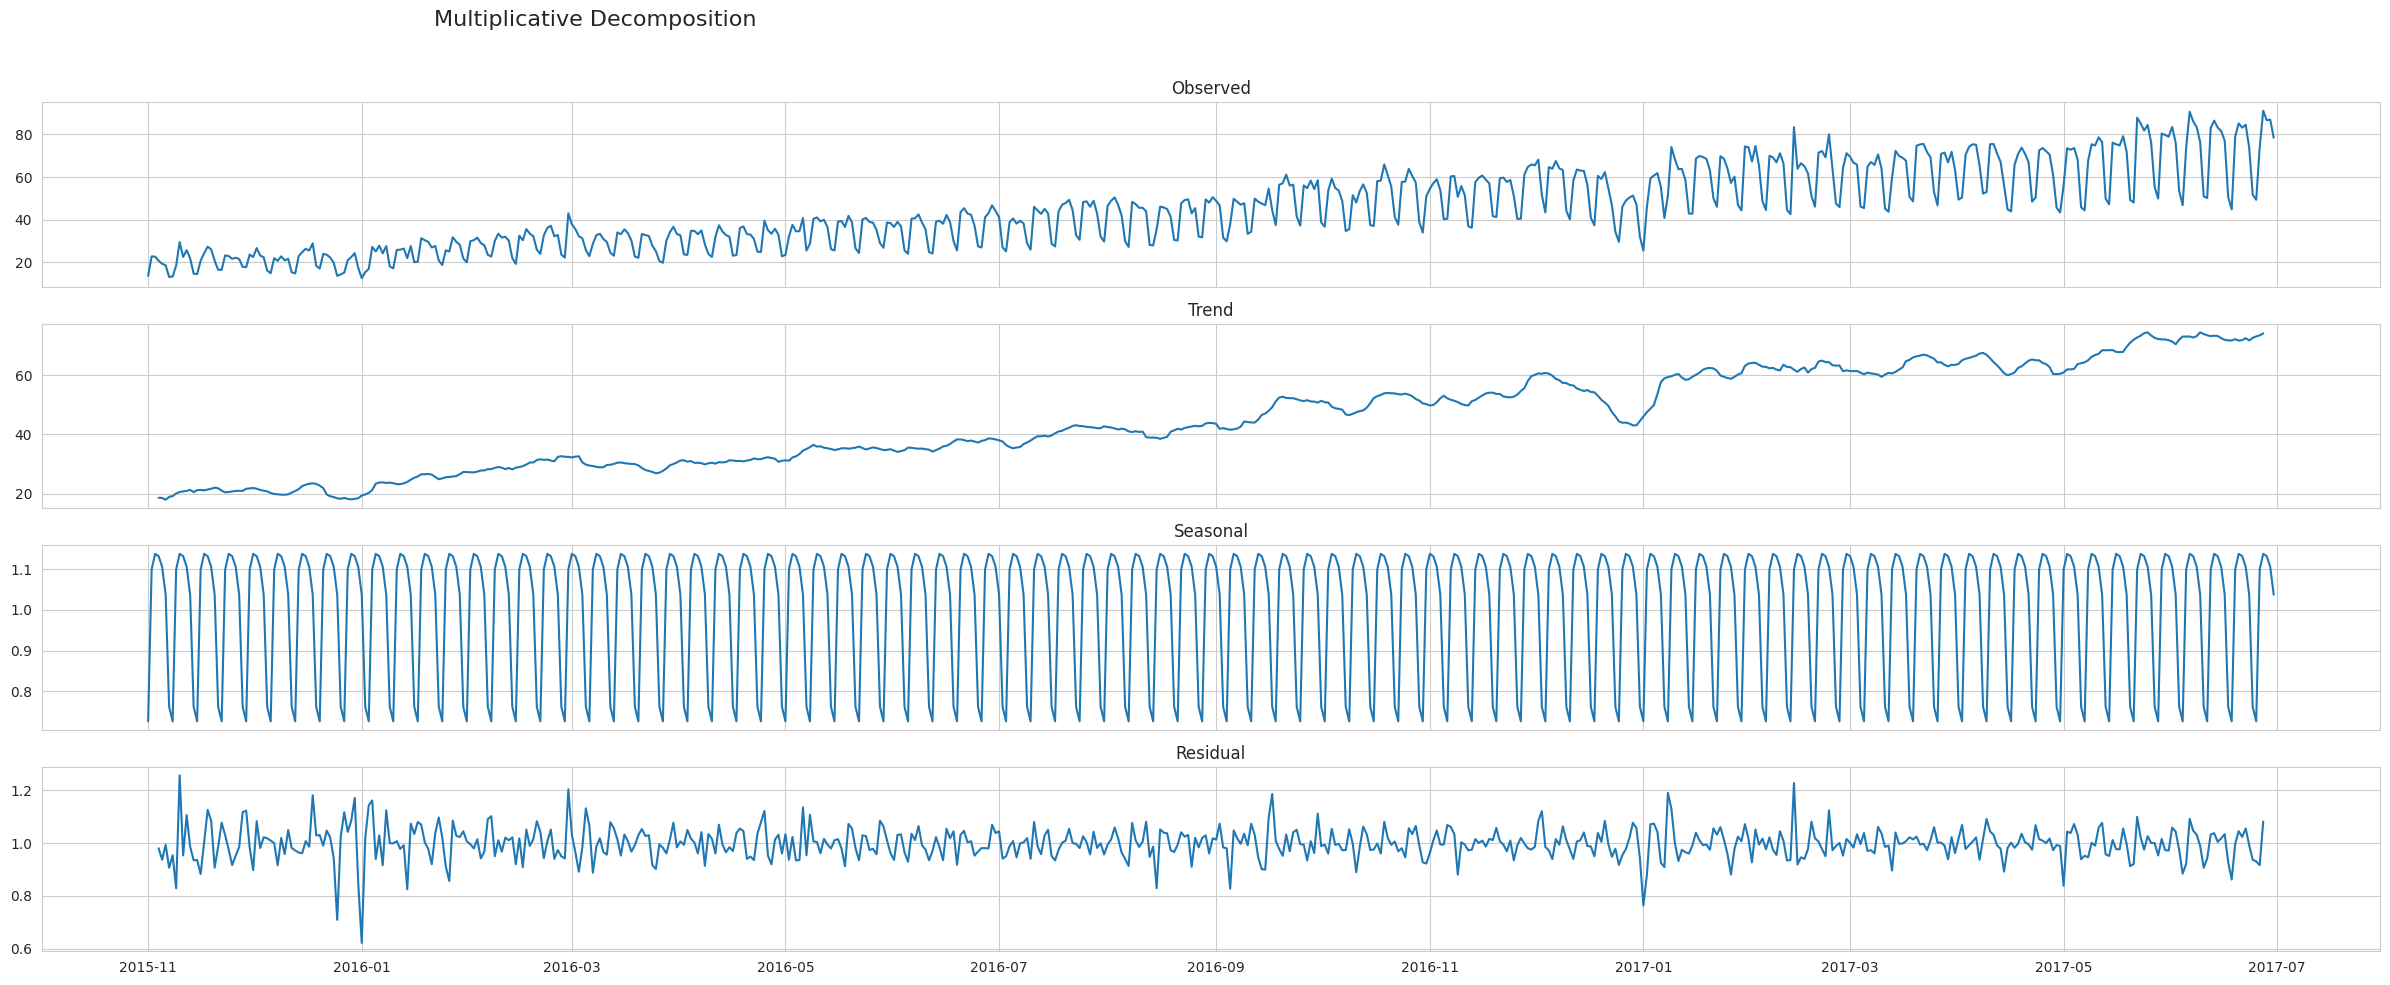

In [31]:
# Improved Additive Decomposition Plot
result_add = seasonal_decompose(df_daily['Vehicles'], model='additive', period=7)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(result_add.observed)
axes[0].set_title('Observed')

axes[1].plot(result_add.trend)
axes[1].set_title('Trend')

axes[2].plot(result_add.seasonal)
axes[2].set_title('Seasonal')

axes[3].plot(result_add.resid)
axes[3].set_title('Residual')

fig.suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0, 2, 0.96])
plt.show()


# Improved Multiplicative Decomposition Plot
result_mult = seasonal_decompose(df_daily['Vehicles'], model='multiplicative', period=7)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(result_mult.observed)
axes[0].set_title('Observed')

axes[1].plot(result_mult.trend)
axes[1].set_title('Trend')

axes[2].plot(result_mult.seasonal)
axes[2].set_title('Seasonal')

axes[3].plot(result_mult.resid)
axes[3].set_title('Residual')

fig.suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0, 2, 0.96])
plt.show()


In [32]:
train_data = df_daily[:-int(len(df_daily) * 0.05)]
test_data = df_daily[-int(len(df_daily) * 0.05):]
# print(df_daily.shape)
# print(test_data.shape)
train_series = train_data['Vehicles']
test_series = test_data['Vehicles']

### BEST ARIMA MODEL

Best Model: ARIMA(9, 1, 3) - AIC: 3235.408813078857
RMSE: 4.949242782772598
MAE: 4.251567208993219
SSE: 734.8501236847994
NMSE: 0.10902985493588037
MAPE: 6.377038716390701%
Accuracy (100 - MAPE): 93.6229612836093%
R² Score: 0.8909701450641196


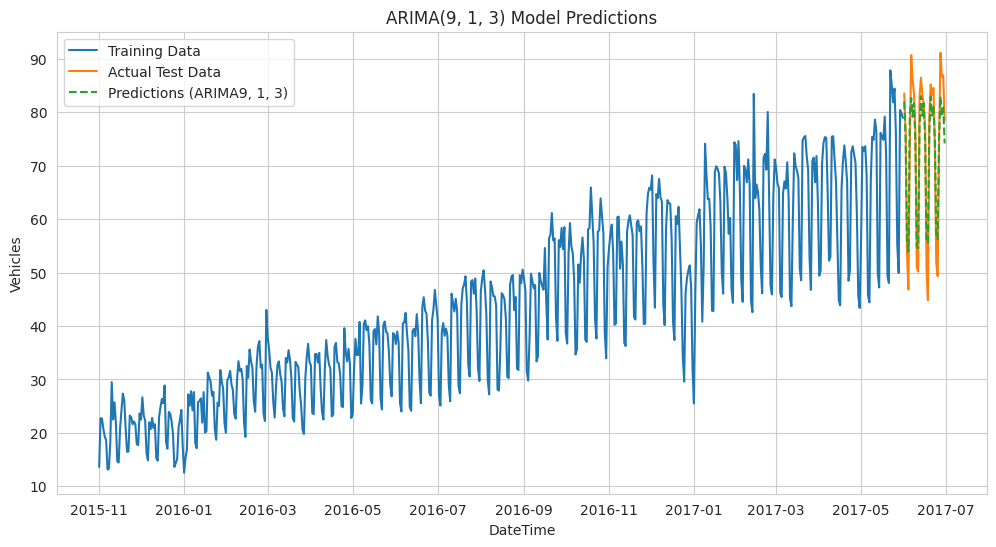

In [34]:
# # import itertools
# # import numpy as np
# # import pandas as pd
# # import matplotlib.pyplot as plt
# # import math
# # from statsmodels.tsa.arima.model import ARIMA
# # from sklearn.metrics import mean_squared_error

# # # Define possible values of p and q
# # p_values = range(0,15)  # Try AR terms from 0 to 5
# # q_values = range(0,15)  # Try MA terms from 0 to 5


# # best_aic = np.inf  # Start with a very high AIC
# # best_pq = None
# # best_model = None

# # # Iterate over all combinations of (p, q)
# # for p, q in itertools.product(p_values, q_values):
# #     try:
# #         # Fit ARMA model (ARIMA with d=0)
# #         model = ARIMA(train_data['Vehicles'], order=(p, 1, q))
# #         results = model.fit()

# #         # Check the AIC value
# #         if results.aic < best_aic:
# #             best_aic = results.aic
# #             best_pq = (p, q)
# #             best_model = results

# #         print(f"ARMA({p}, {q}) - AIC: {results.aic}")
# #     except Exception as e:
# #         print(f"ARMA({p}, {q}) failed: {e}")

# # # Print best (p, q) combination
# # print(f"\nBest Model: ARMA{best_pq} - AIC: {best_aic}")

# # # Make predictions with the best model
# # predictions = best_model.predict(start=len(train_data), end=len(df_daily) - 1)

# # # Calculate RMSE
# # rmse = math.sqrt(mean_squared_error(test_data['Vehicles'], predictions))
# # print(f"RMSE: {rmse}")

# # # Plot predictions
# # plt.figure(figsize=(12, 6))
# # plt.plot(train_data.index, train_data['Vehicles'], label='Training Data')
# # plt.plot(test_data.index, test_data['Vehicles'], label='Actual Test Data')
# # plt.plot(test_data.index, predictions, label=f'Predictions (ARMA{best_pq})', linestyle='dashed')
# # plt.xlabel('DateTime')
# # plt.ylabel('Vehicles')
# # plt.title(f'Best ARMA{best_pq} Model Predictions')
# # plt.legend()
# # plt.show()

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import math
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# # Set the best (p, q) combination directly
# p, q = 7, 10  # Best model: ARMA(7, 10)

# # Fit ARIMA model (ARMA with d=0) with the best p, q values
# model = ARIMA(train_data['Vehicles'], order=(p, 1, q))
# results = model.fit()

# # Print the AIC value
# print(f"Best Model: ARMA({p}, {q}) - AIC: {results.aic}")

# # Make predictions with the best model
# predictions = results.predict(start=len(train_data), end=len(df_daily) - 1)

# # Calculate RMSE
# rmse = math.sqrt(mean_squared_error(test_data['Vehicles'], predictions))
# print(f"RMSE: {rmse}")

# # Plot predictions
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data['Vehicles'], label='Training Data')
# plt.plot(test_data.index, test_data['Vehicles'], label='Actual Test Data')
# plt.plot(test_data.index, predictions, label=f'Predictions (ARMA{p}, {q})', linestyle='dashed')
# plt.xlabel('DateTime')
# plt.ylabel('Vehicles')
# plt.title(f'ARMA({p}, {q}) Model Predictions')
# plt.legend()
# plt.show()







import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the best (p, d, q) combination directly
p, d, q = 9, 1, 3

# Fit ARIMA model with the best (p, d, q) values
model = ARIMA(train_data['Vehicles'], order=(p, d, q))
results = model.fit()

# Print the AIC value
print(f"Best Model: ARIMA({p}, {d}, {q}) - AIC: {results.aic}")

# Make predictions
predictions = results.predict(start=len(train_data), end=len(df_daily) - 1)
actuals = test_data['Vehicles'].values
preds = predictions.values

# Metrics
rmse = math.sqrt(mean_squared_error(actuals, preds))
mae = mean_absolute_error(actuals, preds)
sse = np.sum(np.square(actuals - preds))
nmse = mean_squared_error(actuals, preds) / np.var(actuals)
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
acc = 100 - mape
r2 = r2_score(actuals, preds)

# Print all metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"SSE: {sse}")
print(f"NMSE: {nmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy (100 - MAPE): {acc}%")
print(f"R² Score: {r2}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Vehicles'], label='Training Data')
plt.plot(test_data.index, actuals, label='Actual Test Data')
plt.plot(test_data.index, preds, label=f'Predictions (ARIMA{p}, {d}, {q})', linestyle='dashed')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.title(f'ARIMA({p}, {d}, {q}) Model Predictions')
plt.legend()
plt.show()


### BEST SARIMA MODEL

Model: SARIMA(0, 1, 6)x(4, 1, 14, 7)
AIC: 2507.60


Model: SARIMA(0, 1, 6)x(4, 1, 14, 7)
AIC: 2507.64
RMSE: 5.35
MAE: 4.74
SSE: 859.43
NMSE: 0.1275
MAPE: 6.41%
Accuracy (100 - MAPE): 93.59%
R² Score: 0.8725


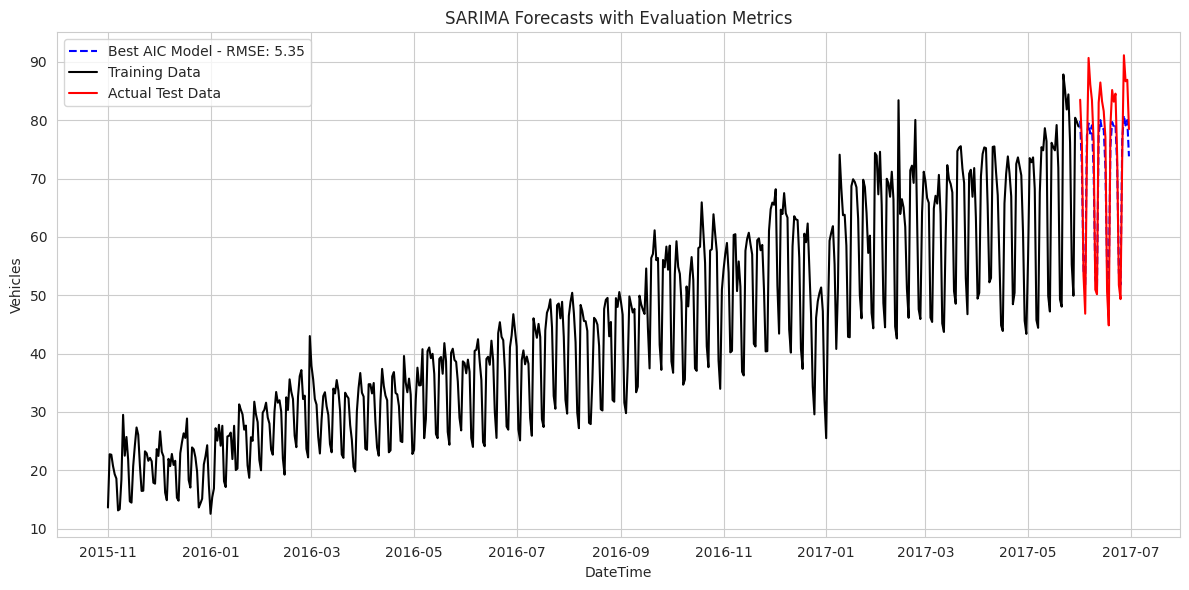

In [35]:
# import itertools
# import random
# import math
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # === Conflict check helper ===
# def has_conflict(order, seasonal_order, s):
#     p, d, q = order
#     P, D, Q, _ = seasonal_order
#     ar_lags = set(range(1, p + 1))
#     seasonal_ar_lags = set(P * s for P in range(1, P + 1))
#     ma_lags = set(range(1, q + 1))
#     seasonal_ma_lags = set(Q * s for Q in range(1, Q + 1))
#     return bool(ar_lags & seasonal_ar_lags or ma_lags & seasonal_ma_lags)

# # === Define parameter ranges ===
# p = q = range(0, 15)
# d = [1]
# s = 7  # weekly seasonality

# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

# # === Filter valid combinations (no conflicts) ===
# valid_combinations = [
#     (order, seasonal_order)
#     for order, seasonal_order in itertools.product(pdq, seasonal_pdq)
#     if not has_conflict(order, seasonal_order, s)
# ]

# # === Randomly select 200 valid combinations ===
# random.seed(42)
# sampled_combinations = random.sample(valid_combinations, 20)

# # === Track best models
# best_aic = float('inf')
# best_aic_model = None
# best_aic_order = None
# best_aic_seasonal = None

# best_rmse = float('inf')
# best_rmse_model = None
# best_rmse_order = None
# best_rmse_seasonal = None

# # === Grid search with sampled combinations
# for order, seasonal_order in sampled_combinations:
#     try:
#         model = SARIMAX(train_data['Vehicles'],
#                         order=order,
#                         seasonal_order=seasonal_order,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         results = model.fit(disp=False)

#         pred = results.predict(start=test_data.index[0],
#                                end=test_data.index[-1])

#         rmse = math.sqrt(mean_squared_error(test_data['Vehicles'], pred))

#         print(f"Trying SARIMA{order}x{seasonal_order} - AIC: {results.aic:.2f}, RMSE: {rmse:.2f}")

#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_aic_model = results
#             best_aic_order = order
#             best_aic_seasonal = seasonal_order

#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_rmse_model = results
#             best_rmse_order = order
#             best_rmse_seasonal = seasonal_order

#     except Exception as e:
#         print(f"Error for SARIMA{order}x{seasonal_order}: {e}")
#         continue

# # === Summary ===
# print("\n=====================")
# print(f"Best AIC Model:    SARIMA{best_aic_order}x{best_aic_seasonal} - AIC: {best_aic:.2f}")
# print(f"Best RMSE Model:   SARIMA{best_rmse_order}x{best_rmse_seasonal} - RMSE: {best_rmse:.2f}")
# print("=====================\n")

# # === Forecast using Best RMSE Model ===
# pred = best_rmse_model.predict(start=test_data.index[0],
#                                end=test_data.index[-1])

# # === Plot results
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data['Vehicles'], label='Training Data')
# plt.plot(test_data.index, test_data['Vehicles'], label='Actual Test Data', color='orange')
# plt.plot(test_data.index, pred, label='Best RMSE Forecast', linestyle='--', color='green')
# plt.xlabel('DateTime')
# plt.ylabel('Vehicles')
# plt.title('SARIMA Forecast (Best RMSE Model)')
# plt.legend()
# plt.tight_layout()
# plt.show()


import math
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the specific SARIMA models to evaluate
models = [
    {"order": (0, 1, 6), "seasonal_order": (4, 1, 14, 7), "label": "Best AIC Model", "color": "blue"},
]

# === Plot setup ===
plt.figure(figsize=(12, 6))

for model_info in models:
    order = model_info["order"]
    seasonal_order = model_info["seasonal_order"]

    try:
        # Fit the SARIMAX model
        model = SARIMAX(train_data['Vehicles'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        # Forecast
        pred = results.predict(start=test_data.index[0], end=test_data.index[-1])
        actual = test_data['Vehicles'].values
        pred_vals = pred.values

        # === Metrics Calculation ===
        rmse = math.sqrt(mean_squared_error(actual, pred_vals))
        mae = mean_absolute_error(actual, pred_vals)
        sse = np.sum(np.square(actual - pred_vals))
        nmse = mean_squared_error(actual, pred_vals) / np.var(actual)
        mape = np.mean(np.abs((actual - pred_vals) / actual)) * 100
        acc = 100 - mape
        r2 = r2_score(actual, pred_vals)

        # Print metrics
        print(f"\nModel: SARIMA{order}x{seasonal_order}")
        print(f"AIC: {results.aic:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"SSE: {sse:.2f}")
        print(f"NMSE: {nmse:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Accuracy (100 - MAPE): {acc:.2f}%")
        print(f"R² Score: {r2:.4f}")

        # Plot predictions
        plt.plot(test_data.index, pred, label=f"{model_info['label']} - RMSE: {rmse:.2f}", linestyle='--', color=model_info["color"])

    except Exception as e:
        print(f"Error for SARIMA{order}x{seasonal_order}: {e}")
        continue


# Plot actual data
plt.plot(train_data.index, train_data['Vehicles'], label='Training Data', color='black')
plt.plot(test_data.index, test_data['Vehicles'], label='Actual Test Data', color='red')

# Plot styling
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.title('SARIMA Forecasts with Evaluation Metrics')
plt.legend()
plt.tight_layout()
plt.show()

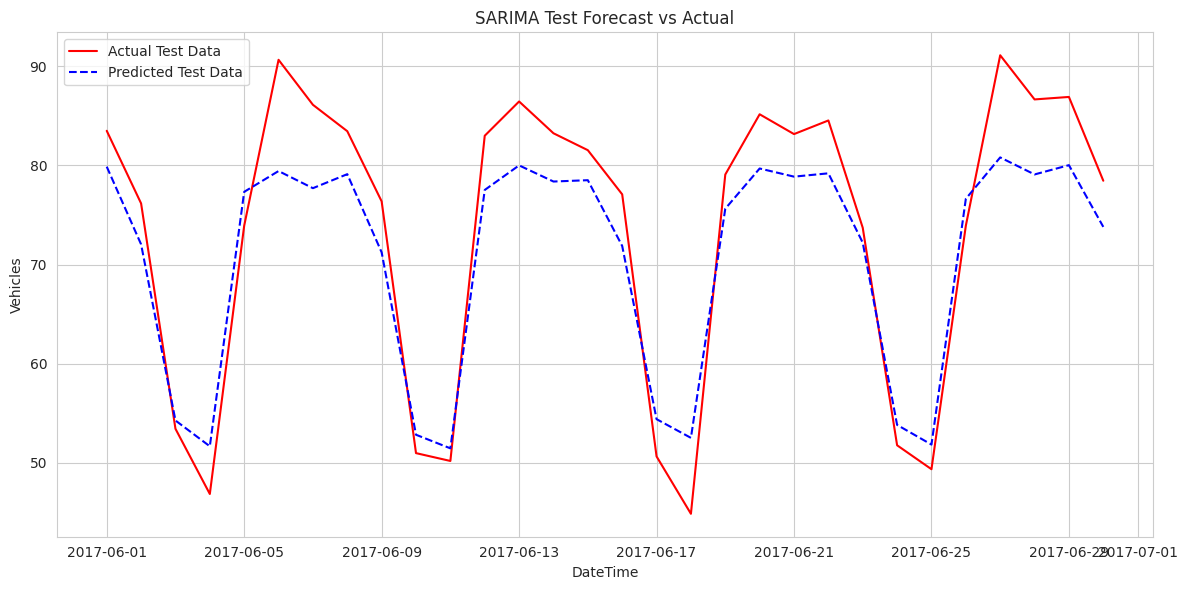

In [36]:
# Plot actual and predicted test data only
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Vehicles'], label='Actual Test Data', color='red')
plt.plot(test_data.index, pred, label='Predicted Test Data', color='blue', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.title('SARIMA Test Forecast vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


### BEST SARIMAX model

Best AIC Model: SARIMAX(0, 1, 6)x(4, 1, 14, 7)
AIC: 2098.35

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import math
import holidays

# STEP 1: Load your data (assumes datetime index and 'Vehicles' column)
# df_daily = pd.read_csv('your_file.csv', parse_dates=['Date'], index_col='Date')
# or if already loaded:
# df_daily.index = pd.to_datetime(df_daily.index)

# STEP 2: Add Holiday & WorkingDay Features (for USA)
usa_holidays = holidays.UnitedStates()
df_daily['Holiday'] = df_daily.index.to_series().apply(lambda x: 1 if x in usa_holidays else 0)
df_daily['WorkingDay'] = ((df_daily.index.dayofweek < 5) & (df_daily['Holiday'] == 0)).astype(int)

# Optional: Lag features (improves model)
df_daily['Lag1'] = df_daily['Vehicles'].shift(1)
df_daily['Lag7'] = df_daily['Vehicles'].shift(7)

# Drop rows with NaN (from lags)
df_daily.dropna(inplace=True)

# STEP 3: Train-test split (last 10% as test)
train_size = int(len(df_daily) * 0.9)
train_data = df_daily.iloc[:train_size]
test_data = df_daily.iloc[train_size:]

exog_cols = ['Holiday', 'WorkingDay', 'Lag1', 'Lag7']
exog_train = train_data[exog_cols]
exog_test = test_data[exog_cols]


Best AIC Model: SARIMAX(0, 1, 6)x(4, 1, 14, 7)
AIC: 2098.34
RMSE: 5.80
MAE: 4.20
SSE: 1880.73
NMSE: 0.1535
MAPE: 6.19%
Accuracy (100 - MAPE): 93.81%
R² Score: 0.8465


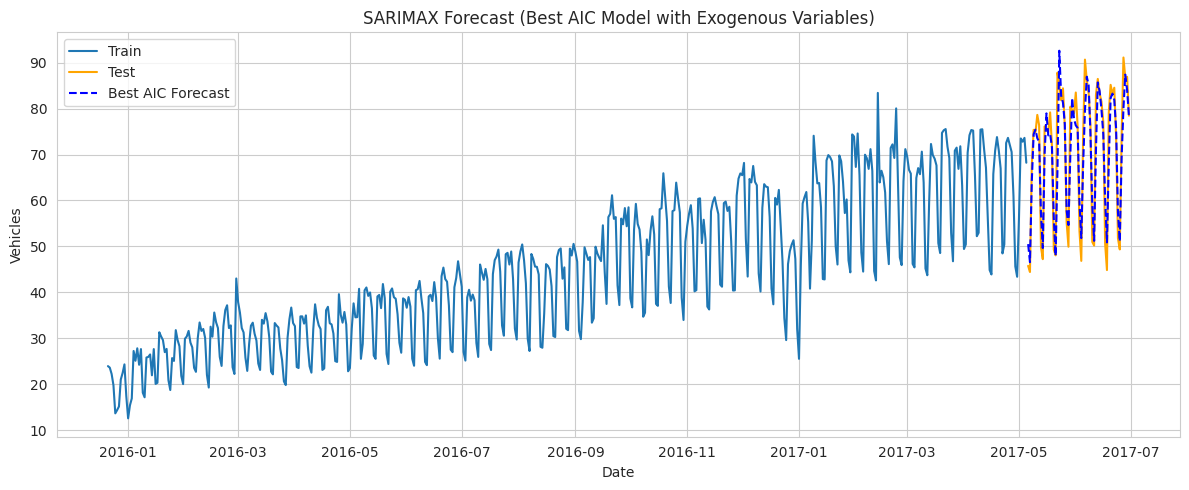

In [40]:
# import itertools
# import random
# import math
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # ==== Function to avoid lag conflicts ====
# def has_conflicting_lags(order, seasonal_order, seasonal_period):
#     p, d, q = order
#     P, D, Q, s = seasonal_order

#     # AR lags
#     ar_lags = set(range(1, p + 1))
#     seasonal_ar_lags = set(P * s for P in range(1, P + 1))

#     # MA lags
#     ma_lags = set(range(1, q + 1))
#     seasonal_ma_lags = set(Q * s for Q in range(1, Q + 1))

#     # Check for conflicts
#     ar_conflict = ar_lags & seasonal_ar_lags
#     ma_conflict = ma_lags & seasonal_ma_lags

#     return bool(ar_conflict or ma_conflict)

# # ==== Parameter space ====
# p = q = range(0, 15)
# d = [1]
# s = 7  # seasonal cycle

# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

# # ==== Filter valid combinations to avoid lag conflicts ====
# valid_combinations = [
#     (order, seasonal_order)
#     for order, seasonal_order in itertools.product(pdq, seasonal_pdq)
#     if not has_conflicting_lags(order, seasonal_order, s)
# ]

# # ==== Random sample of 200 from valid combinations ====
# random.seed(42)
# sampled_combinations = random.sample(valid_combinations, 20)

# # ==== Track best AIC and RMSE models ====
# best_aic = float('inf')
# best_aic_model = None
# best_aic_order = None
# best_aic_seasonal_order = None

# best_rmse = float('inf')
# best_rmse_model = None
# best_rmse_order = None
# best_rmse_seasonal_order = None

# # ==== Run SARIMAX on 200 random combinations ====
# for order, seasonal_order in sampled_combinations:
#     try:
#         model = SARIMAX(train_data['Vehicles'],
#                         exog=exog_train,
#                         order=order,
#                         seasonal_order=seasonal_order,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         results = model.fit(disp=False)
#         pred = results.predict(start=test_data.index[0], end=test_data.index[-1], exog=exog_test)
#         rmse = math.sqrt(mean_squared_error(test_data['Vehicles'], pred))

#         print(f"Trying SARIMAX{order}x{seasonal_order} - AIC: {results.aic:.2f}, RMSE: {rmse:.2f}")

#         # Track best AIC
#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_aic_model = results
#             best_aic_order = order
#             best_aic_seasonal_order = seasonal_order

#         # Track best RMSE
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_rmse_model = results
#             best_rmse_order = order
#             best_rmse_seasonal_order = seasonal_order

#     except Exception as e:
#         print(f"Error for SARIMAX{order}x{seasonal_order}: {e}")
#         continue

# # ==== Output best models ====
# print("\n=======================")
# print(f"Best AIC Model: SARIMAX{best_aic_order}x{best_aic_seasonal_order} - AIC: {best_aic:.2f}")
# print(f"Best RMSE Model: SARIMAX{best_rmse_order}x{best_rmse_seasonal_order} - RMSE: {best_rmse:.2f}")
# print("=======================\n")

# # ==== Plot best RMSE forecast ====
# pred = best_rmse_model.predict(start=test_data.index[0], end=test_data.index[-1], exog=exog_test)

# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data['Vehicles'], label='Train')
# plt.plot(test_data.index, test_data['Vehicles'], label='Test', color='orange')
# plt.plot(test_data.index, pred, label='Best RMSE Forecast', linestyle='--', color='green')
# plt.title('SARIMAX Forecast (Best RMSE Model)')
# plt.xlabel('Date')
# plt.ylabel('Vehicles')
# plt.legend()
# plt.tight_layout()
# plt.show()

import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==== Define the Best AIC Model Parameters ====
best_aic_order = (0, 1, 6)
best_aic_seasonal_order = (4, 1, 14, 7)

# ==== Fit Best AIC Model with Exogenous Variables ====
model_aic = SARIMAX(train_data['Vehicles'],
                    exog=exog_train,
                    order=best_aic_order,
                    seasonal_order=best_aic_seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

results_aic = model_aic.fit(disp=False)

# ==== Predict ====
pred_aic = results_aic.predict(start=test_data.index[0],
                                end=test_data.index[-1],
                                exog=exog_test)

# ==== Evaluation Metrics ====
actual = test_data['Vehicles'].values
predicted = pred_aic.values

rmse = math.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
sse = np.sum(np.square(actual - predicted))
nmse = mean_squared_error(actual, predicted) / np.var(actual)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
acc = 100 - mape
r2 = r2_score(actual, predicted)

# ==== Print Model Info and Metrics ====
print(f"Best AIC Model: SARIMAX{best_aic_order}x{best_aic_seasonal_order}")
print(f"AIC: {results_aic.aic:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"SSE: {sse:.2f}")
print(f"NMSE: {nmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy (100 - MAPE): {acc:.2f}%")
print(f"R² Score: {r2:.4f}")

# ==== Plot ====
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data['Vehicles'], label='Train')
plt.plot(test_data.index, test_data['Vehicles'], label='Test', color='orange')
plt.plot(test_data.index, pred_aic, label='Best AIC Forecast', linestyle='--', color='blue')
plt.title('SARIMAX Forecast (Best AIC Model with Exogenous Variables)')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.tight_layout()
plt.show()



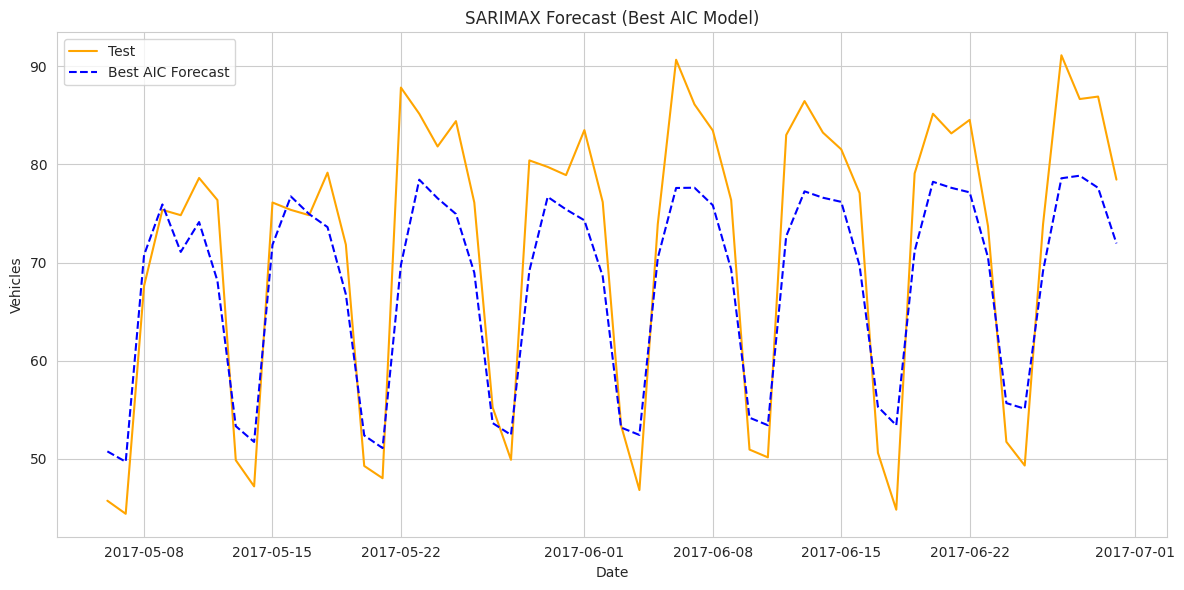

In [38]:
# Plot actual and predicted test data only
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Vehicles'], label='Test', color='orange')
plt.plot(test_data.index, pred_aic, label='Best AIC Forecast', linestyle='--', color='blue')
plt.title('SARIMAX Forecast (Best AIC Model)')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.tight_layout()
plt.show()


###  RNN, LSTM , GRU

In [46]:
# prompt: do minmaxscaller on vehicles column

from sklearn.preprocessing import MinMaxScaler

# Assuming 'Vehicles' column is already part of your dataframe (df_daily)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your training data
scaler.fit(train_data[['Vehicles']])

# Transform the 'Vehicles' column in both training and testing datasets
train_data['Vehicles'] = scaler.transform(train_data[['Vehicles']])
test_data['Vehicles'] = scaler.transform(test_data[['Vehicles']])

# Now 'Vehicles' contains the scaled 'Vehicles' values
# print(train_data.head())
# print(test_data.head())


## RNN

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

📊 Evaluation Metrics (SimpleRNN):
Root Mean Squared Error (RMSE): 4.3238
Mean Absolute Error (MAE): 3.1060
Sum of Squared Errors (SSE): 766.52
Normalized Mean Squared Error (NMSE): 0.0858
Mean Absolute Percentage Error (MAPE): 4.44%
Accuracy (100 − MAPE): 95.56%
R² Score: 0.9142


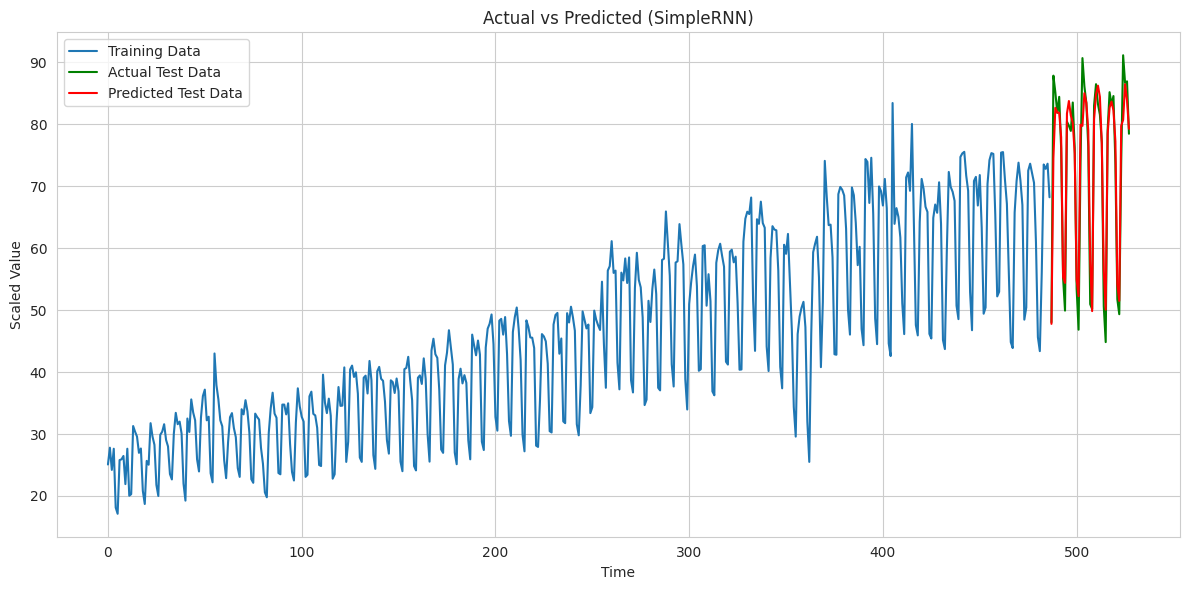

In [43]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Parameters ---
timesteps = 15

# === Sequence Creation ===
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

# Apply to scaled data
trainX, trainy = create_sequences(train_data['Vehicles'].values, timesteps)
testX, testy = create_sequences(test_data['Vehicles'].values, timesteps)

# Reshape for RNN
trainX = trainX.reshape(trainX.shape[0], timesteps, 1)
testX = testX.reshape(testX.shape[0], timesteps, 1)

# === SimpleRNN Model ===
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(trainX, trainy, epochs=50, batch_size=32, verbose=0)

# Predict
predictions = model.predict(testX).flatten()
actual = testy.flatten()

# === Metrics Calculation ===
rmse = math.sqrt(mean_squared_error(actual, predictions))
mae = mean_absolute_error(actual, predictions)
sse = np.sum(np.square(actual - predictions))
nmse = mean_squared_error(actual, predictions) / np.var(actual)
mape = np.mean(np.abs((actual - predictions) / actual)) * 100
accuracy = 100 - mape
r2 = r2_score(actual, predictions)

# === AIC Approximation for RNN ===
# AIC = n * ln(RSS/n) + 2k
# where k = number of parameters, n = number of observations
n = len(actual)
k = model.count_params()
rss = sse

# === Print All Metrics ===
print(f"\n📊 Evaluation Metrics (SimpleRNN):")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.2f}")
print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (100 − MAPE): {accuracy:.2f}%")
print(f"R² Score: {r2:.4f}")

# === Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(range(len(trainy)), trainy, label='Training Data')
plt.plot(range(len(trainy), len(trainy) + len(actual)), actual, label='Actual Test Data', color='green')
plt.plot(range(len(trainy), len(trainy) + len(predictions)), predictions, label='Predicted Test Data', color='red')
plt.title('Actual vs Predicted (SimpleRNN)')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


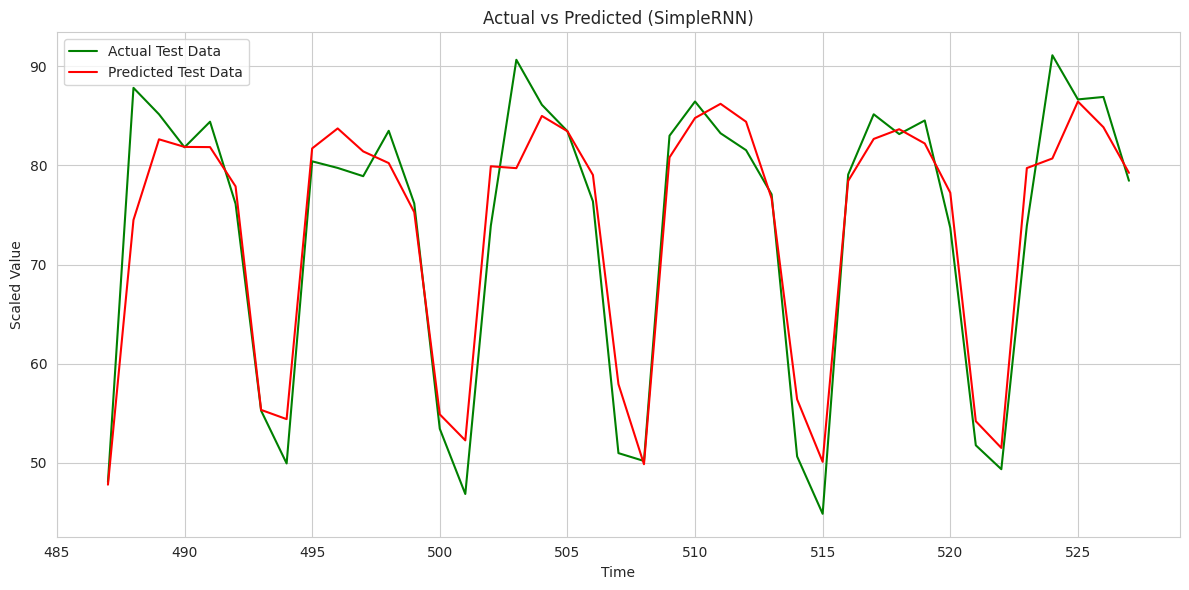

In [44]:

# Plot training data
plt.figure(figsize=(12, 6))

# Plot actual and predicted test data
plt.plot(range(len(trainy), len(trainy) + len(testy)), testy, label='Actual Test Data', color='green')
plt.plot(range(len(trainy), len(trainy) + len(predictions)), predictions, label='Predicted Test Data', color='red')

plt.title('Actual vs Predicted (SimpleRNN)')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Parameters ===
timesteps = 1  # You can adjust based on sequence design

# === Prepare Data ===
trainX = np.array(train_data['Vehicles']).reshape(len(train_data), timesteps, 1)
testX = np.array(test_data['Vehicles']).reshape(len(test_data), timesteps, 1)
trainy = np.array(train_data['Vehicles'])
testy = np.array(test_data['Vehicles'])

# === Define LSTM Model ===
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# === Train the Model ===
model.fit(trainX, trainy, epochs=50, batch_size=32, verbose=0)

# === Predict ===
predictions = model.predict(testX)

# === Inverse Transform (if using scaler) ===
# Assumes 'scaler' was used during preprocessing
predictions_inv = scaler.inverse_transform(predictions)
testy_inv = scaler.inverse_transform(testy.reshape(-1, 1))

# === Metrics Calculation ===
rmse = np.sqrt(mean_squared_error(testy_inv, predictions_inv))
mae = mean_absolute_error(testy_inv, predictions_inv)
sse = np.sum(np.square(testy_inv - predictions_inv))
nmse = mean_squared_error(testy_inv, predictions_inv) / np.var(testy_inv)
mape = np.mean(np.abs((testy_inv - predictions_inv) / testy_inv)) * 100
accuracy = 100 - mape
r2 = r2_score(testy_inv, predictions_inv)

# === Print Metrics ===
print(f"\n📊 Evaluation Metrics (LSTM):")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.2f}")
print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (100 − MAPE): {accuracy:.2f}%")
print(f"R² Score: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

📊 Evaluation Metrics (LSTM):
Root Mean Squared Error (RMSE): 1.9365
Mean Absolute Error (MAE): 1.6386
Sum of Squared Errors (SSE): 210.00
Normalized Mean Squared Error (NMSE): 0.0171
Mean Absolute Percentage Error (MAPE): 2.18%
Accuracy (100 − MAPE): 97.82%
R² Score: 0.9829


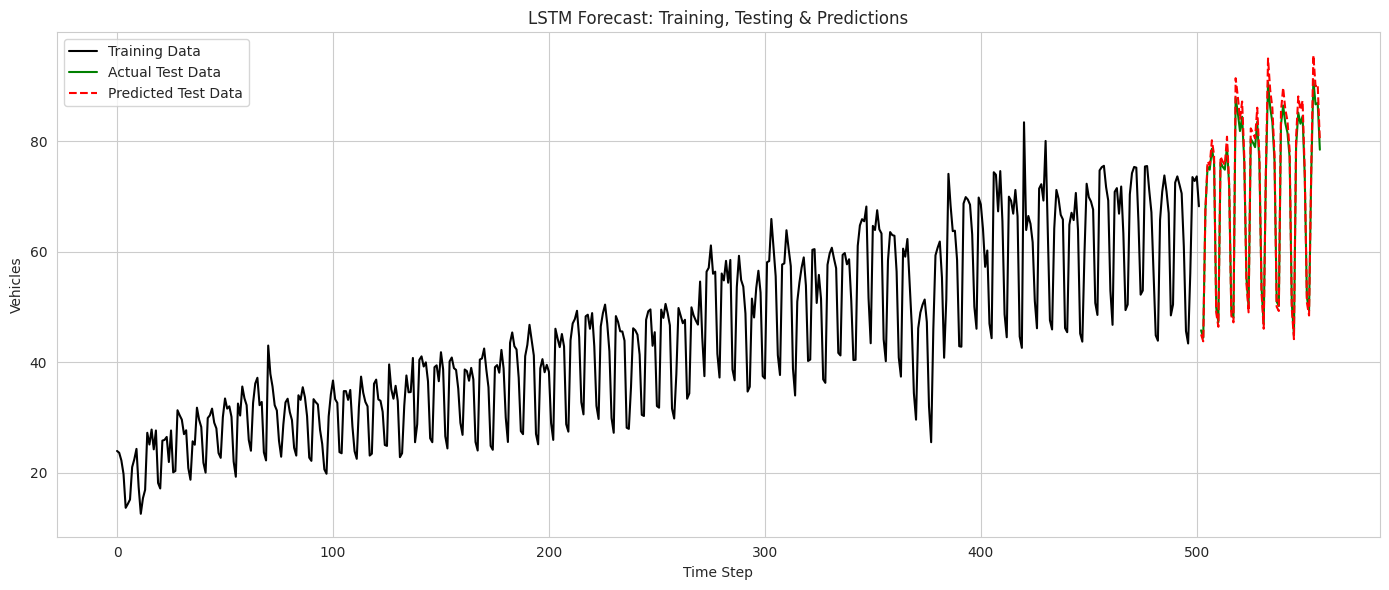

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Combine all for smooth indexing
# Inverse-transform full train data (if needed)
trainy_inv = scaler.inverse_transform(train_data['Vehicles'].values.reshape(-1, 1))
# === Build x-axis indexes ===
train_len = len(trainy_inv)
test_len = len(testy_inv)

# === Plot ===
plt.figure(figsize=(14, 6))
# Plot training data
plt.plot(range(train_len), trainy_inv, label='Training Data', color='black')
# Plot actual test data
plt.plot(range(train_len, train_len + test_len), testy_inv, label='Actual Test Data', color='green')
# Plot predicted test data
plt.plot(range(train_len, train_len + test_len), predictions_inv, label='Predicted Test Data', color='red', linestyle='--')
# === Styling ===
plt.title('LSTM Forecast: Training, Testing & Predictions')
plt.xlabel('Time Step')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


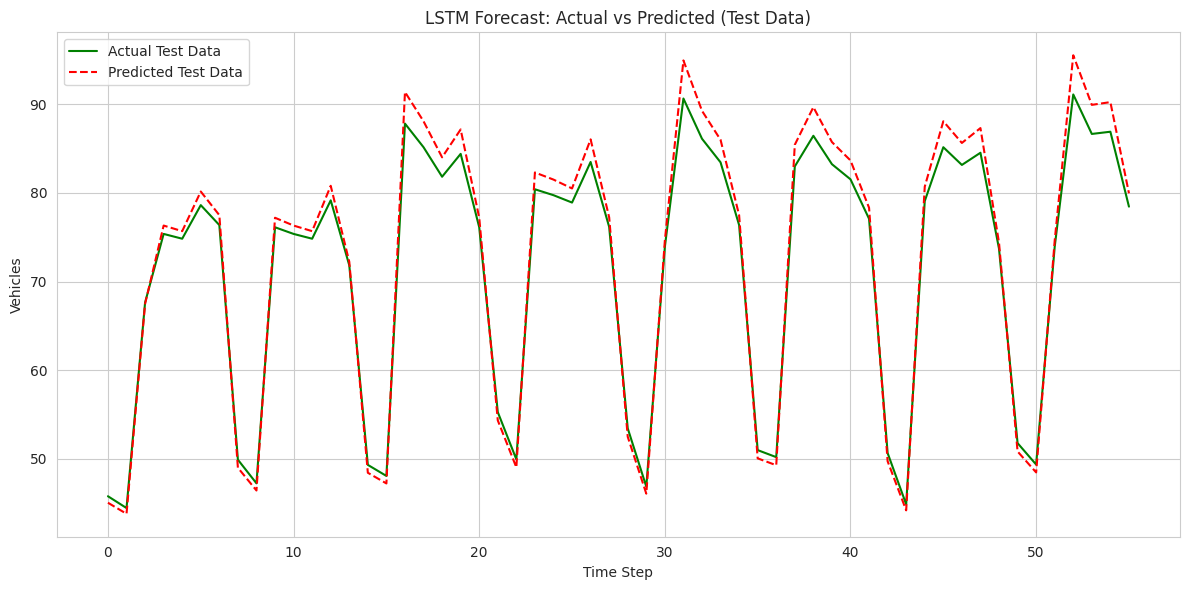

In [55]:
import matplotlib.pyplot as plt

# === Plot ===
plt.figure(figsize=(12, 6))

# Plot actual test data
plt.plot(testy_inv, label='Actual Test Data', color='green')

# Plot predicted test data
plt.plot(predictions_inv, label='Predicted Test Data', color='red', linestyle='--')

# === Styling ===
plt.title('LSTM Forecast: Actual vs Predicted (Test Data)')
plt.xlabel('Time Step')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

📊 Evaluation Metrics (GRU):
Root Mean Squared Error (RMSE): 0.6956
Mean Absolute Error (MAE): 0.6004
Sum of Squared Errors (SSE): 27.10
Normalized Mean Squared Error (NMSE): 0.0022
Mean Absolute Percentage Error (MAPE): 0.80%
Accuracy (100 − MAPE): 99.20%
R² Score: 0.9978


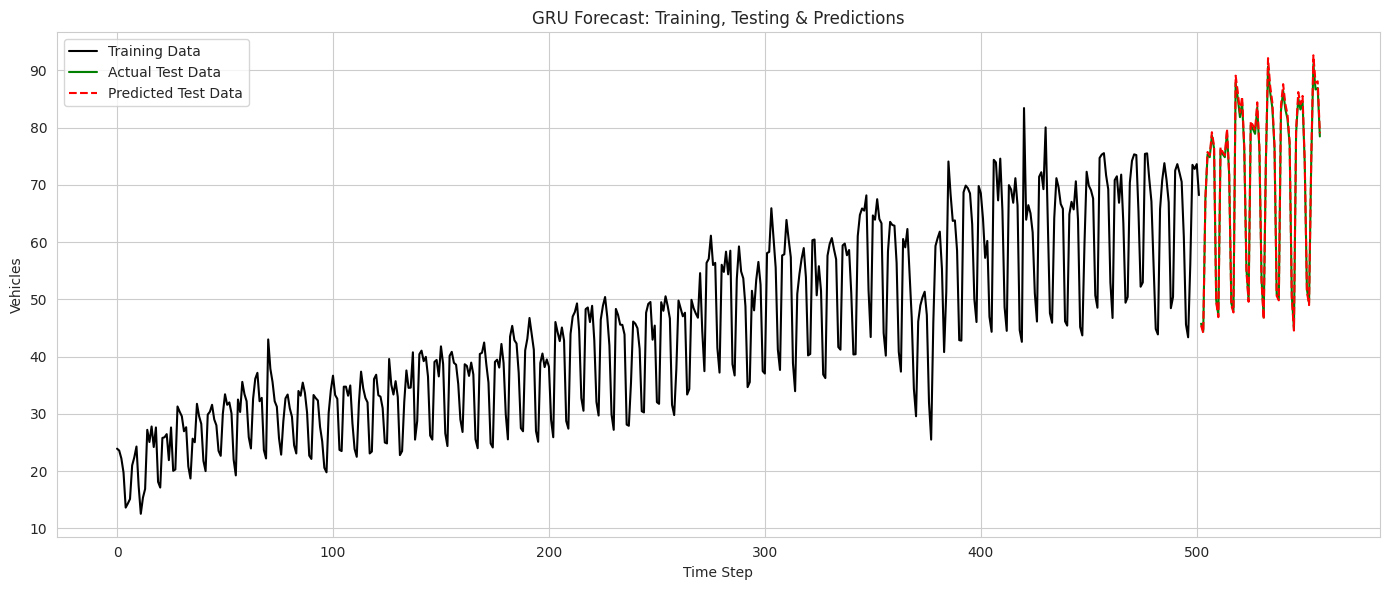

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Parameters ===
timesteps = 1  # You can increase if you're using sequences

# === Prepare Data ===
trainX = np.array(train_data['Vehicles']).reshape(len(train_data), timesteps, 1)
testX = np.array(test_data['Vehicles']).reshape(len(test_data), timesteps, 1)
trainy = np.array(train_data['Vehicles'])
testy = np.array(test_data['Vehicles'])

# === Build GRU Model ===
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# === Train the Model ===
model.fit(trainX, trainy, epochs=50, batch_size=32, verbose=0)

# === Predict ===
predictions = model.predict(testX)

# === Inverse Transform ===
predictions_inv = scaler.inverse_transform(predictions)
testy_inv = scaler.inverse_transform(testy.reshape(-1, 1))
trainy_inv = scaler.inverse_transform(trainy.reshape(-1, 1))

# === Metrics Calculation ===
rmse = np.sqrt(mean_squared_error(testy_inv, predictions_inv))
mae = mean_absolute_error(testy_inv, predictions_inv)
sse = np.sum(np.square(testy_inv - predictions_inv))
nmse = mean_squared_error(testy_inv, predictions_inv) / np.var(testy_inv)
mape = np.mean(np.abs((testy_inv - predictions_inv) / testy_inv)) * 100
accuracy = 100 - mape
r2 = r2_score(testy_inv, predictions_inv)

# === Print Metrics ===
print(f"\n📊 Evaluation Metrics (GRU):")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.2f}")
print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy (100 − MAPE): {accuracy:.2f}%")
print(f"R² Score: {r2:.4f}")

# === Plot Full Data ===
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(range(len(trainy_inv)), trainy_inv, label='Training Data', color='black')

# Plot actual test data
plt.plot(range(len(trainy_inv), len(trainy_inv) + len(testy_inv)), testy_inv, label='Actual Test Data', color='green')

# Plot predicted test data
plt.plot(range(len(trainy_inv), len(trainy_inv) + len(predictions_inv)), predictions_inv, label='Predicted Test Data', color='red', linestyle='--')

# === Plot Styling ===
plt.title('GRU Forecast: Training, Testing & Predictions')
plt.xlabel('Time Step')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


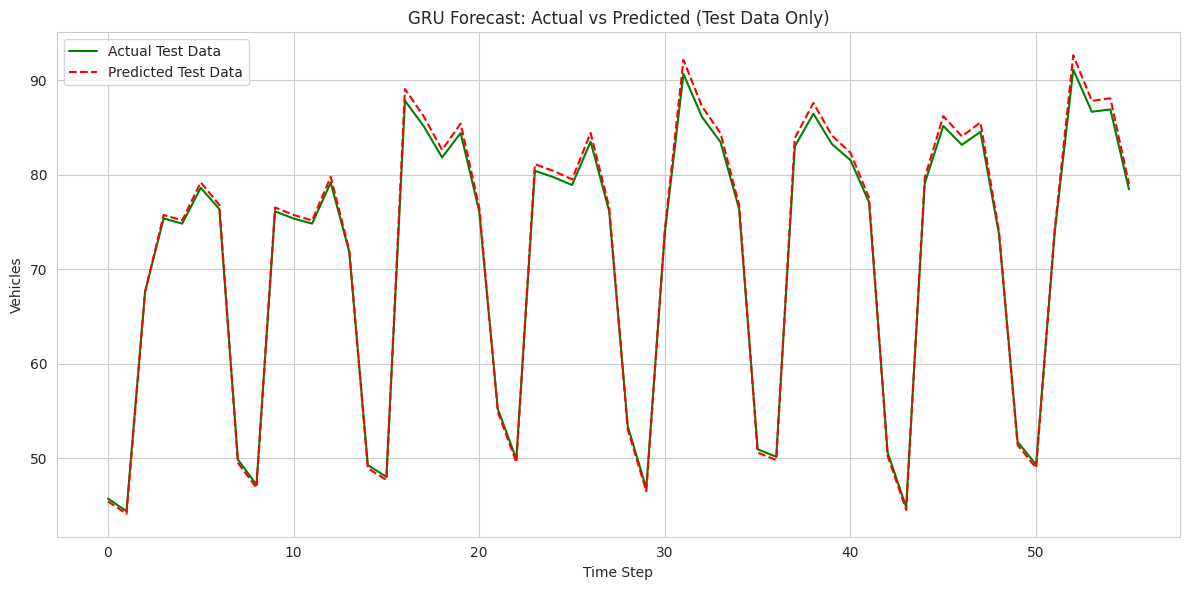

In [58]:
import matplotlib.pyplot as plt

# === Plot Test and Prediction Only ===
plt.figure(figsize=(12, 6))

# Plot actual test data
plt.plot(testy_inv, label='Actual Test Data', color='green')

# Plot predicted test data
plt.plot(predictions_inv, label='Predicted Test Data', color='red', linestyle='--')

# === Styling ===
plt.title('GRU Forecast: Actual vs Predicted (Test Data Only)')
plt.xlabel('Time Step')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
